# PyTorch:  Neural Network for Multiclass Classification

In [2]:
import numpy as np
import matplotlib.pyplot as plt  
from   matplotlib import colors

import torch
import torch.nn as nn
from   torch.utils.data import Dataset, DataLoader

## Toy dataset

Consider a two-dimensional feature space. There are objects of three kinds (classification into three classes).<br>
Let's generate 1200 objects and draw them in the feature space.
For training data, Y must contain an integer - the class number!

X: torch.Size([1200, 2]) torch.float32 Y: torch.Size([1200]) torch.int64


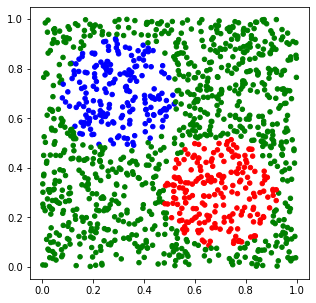

In [4]:
X = torch.rand (1200,2)                       
C1 = (torch.sum((X - torch.tensor([0.7, 0.3]))**2, axis=1) < 0.05).float().view(-1,1)
C2 = (torch.sum((X - torch.tensor([0.3, 0.7]))**2, axis=1) < 0.05).float().view(-1,1)
C3 = (C1 * C2 == 0).float().view(-1,1)

Y = torch.argmax(torch.cat([C1,C2,C3], 1), 1)      # class numbers
   
idx = torch.randperm( len(X) )                     # permuted index list
X, Y = X[idx], Y[idx]      

print("X:", X.shape, X.dtype, "Y:", Y.shape, Y.dtype)   # !!!! for Y - number of class int64         
 
plt.figure (figsize=(5, 5)) 
cmap = colors.ListedColormap(['red', 'blue', 'green'])
plt.scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy(),  s=20, cmap=cmap)        
plt.show()                                                  

## Batch Loader

In [5]:
class ToyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

num_trn = int(len(X)*0.8)
loader_trn = DataLoader( ToyDataset(X[:num_trn], Y[:num_trn]), batch_size=128, shuffle=True,  pin_memory=True)
loader_tst = DataLoader( ToyDataset(X[num_trn:], Y[num_trn:]), batch_size=128, shuffle=False,  pin_memory=True)

## Network

The three outputs of the network correspond to the probabilities of each of the three classes.
Since we use the `CrossEntropyLoss`, there is no need to set the `softmax` function at the network output!!!
$$
\mathrm{CrossEntropyLoss}(y, c) = -\,w_c\,\log\left( \frac{\exp {y_{ic}}}{ \sum_\alpha \exp{y_{i\alpha}}}\right).
$$

In [24]:
class Model_FC(nn.Module):
    def __init__(self, nX, nY, hiddens = []):        
        super(Model_FC, self).__init__()        # ancestor constructor with this name
        
        seq = []
        neurons = [nX] + hiddens + [nY]
        for i in range(len(neurons)-1):
            seq.append( nn.Linear(neurons[i], neurons[i+1]) )
            if i < len(neurons)-2:
                seq.append( nn.ReLU() )
                
        self.model =  nn.Sequential(*seq)
          
    def forward(self, x):                        # задаётся прямой проход
        return self.model(x)       

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Model_FC(nX=2, nY=3, hiddens=[5,7])
model.to(device)

print(model)

cpu
Model_FC(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=3, bias=True)
  )
)


## Network learning


In [35]:
loss      = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   

In [33]:
def fit(model, loader, train=True):       
    totLoss, totAcc = 0, 0

    model.train(train)                                 # important for Dropout, BatchNorm layers
    for sample in loader:             
        xb, yb = sample                                # current batch
        xb=xb.to(device)
        yb=yb.to(device)
              
        y = model(xb)                                   # forward propagation
        L = loss(y, yb)                                 # calculate the loss
  
        if train:                                       # we are in learning mode
            optimizer.zero_grad()                       # reset the gradients        
            L.backward()                                # calculate gradients           
            optimizer.step()                            # adjusting parameters
                                     
        totLoss += L.detach()                           # total loss (item from graph)        
        a = y.data.argmax(axis=1)
        totAcc += ( (a == yb).float().mean() )          # class definition accuracy
         
    return totLoss.item()/len(loader), totAcc.item()/len(loader)

def plot(history):
    h = np.array(history)                               # learning output
    plt.figure(figsize=(16,5), facecolor ='w')              
    plt.subplot(1, 2, 1);  plt.xlabel('epoch'); plt.ylabel('loss')  
    plt.title(f"loss_trn: {h[-1,1]:.4f}, loss_tst: {h[-1,2]:.4f}")
    plt.plot(h[:,0], h[:, 1], color="b"); 
    plt.plot(h[:,0], h[:, 2], color="g"); 
    plt.legend( ['loss_trn', 'loss_st'], loc='upper right')
    plt.subplot(1, 2, 2);  plt.xlabel('epoch'); plt.ylabel('accuarcy')
    plt.title(f"acc_trn: {h[-1,3]:.4f}, acc_tst: {h[-1,4]:.4f}")
    plt.plot(h[:,0], h[:, 3], color="b")
    plt.plot(h[:,0], h[:, 4], color="g")
    plt.legend( ['acc_trn', 'acc_st'], loc='lower right')
    plt.show()        

before:      loss: 1.3482 accuracy: 0.1582
epoch:   500 loss: 0.10436 (0.07910) acc: 0.9521 (0.9676) 14.03s

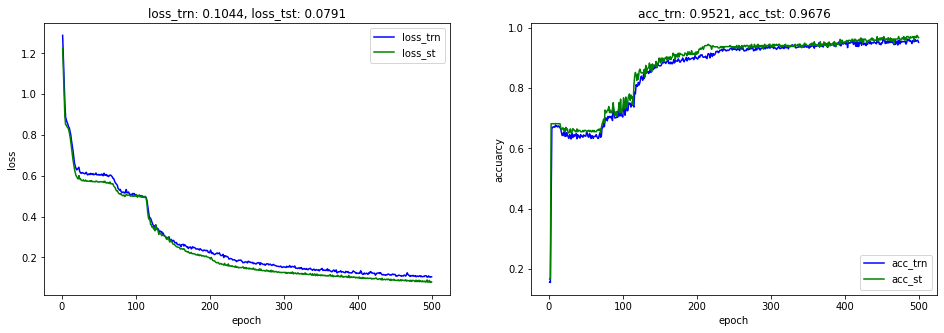

epoch:  1000 loss: 0.07343 (0.05428) acc: 0.9775 (0.9760) 14.20s

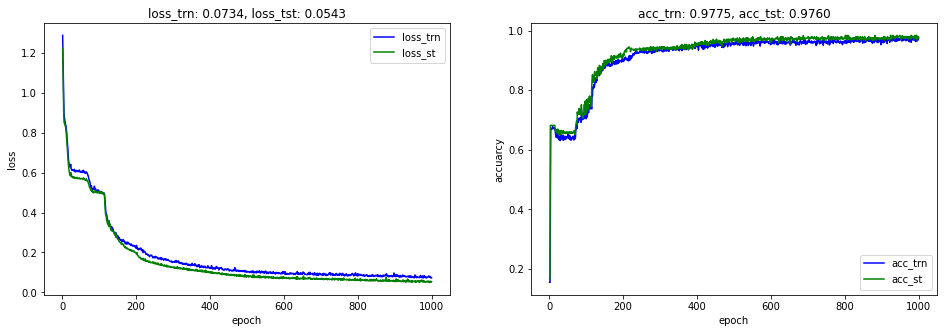

In [36]:
import time
model.to(device)
print( "before:      loss: %.4f accuracy: %.4f" %  fit(model, loader_trn, train=False) )
history, losses, accs = [], [], []
 
beg = time.process_time()
epochs = 1000                                           # number of epochs
for epoch in range(1, epochs+1):                          
    L_trn, A_trn = fit(model, loader_trn)                # one epoch    
    L_tst, A_tst = fit(model, loader_tst, train=False)   # testing
    
    history.append([epoch, L_trn, L_tst, A_trn, A_tst])
    
    if epoch % 100 == 0 or epoch == epochs:   # learning output          
        print(f"\repoch: {epoch:5d} loss: {L_trn:.5f} ({L_tst:.5f}) acc: {A_trn:.4f} ({A_tst:.4f}) {time.process_time()-beg:.2f}s", end="")   
        beg = time.process_time()

    if epoch % 500 == 0 or epoch == epochs:   # learning output          
        plot(history)
        
    

## Classification visualization

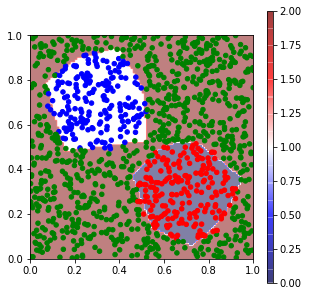

In [37]:
X_MIN, X_MAX, X_NUM = 0., 1., 100
Y_MIN, Y_MAX, Y_NUM = 0., 1., 100

x = np.linspace(X_MIN, X_MAX, X_NUM, dtype=np.float32)
y = np.linspace(Y_MIN, Y_MAX, Y_NUM, dtype=np.float32)
x, y =  np.meshgrid(x, y)    

inp = torch.cat([torch.tensor(x).view(-1,1), torch.tensor(y).view(-1,1)], 1)

z = model(inp.to(device)).detach().to('cpu')
z = torch.argmax( torch.softmax(z, 1), 1 ).view(X_NUM, Y_NUM)
    
plt.figure(figsize=(5,5))
plt.imshow(z, extent=[X_MIN, X_MAX, Y_MIN, Y_MAX],  origin='lower', cmap='seismic', alpha=0.5)
plt.colorbar(aspect=50) 
cmap = colors.ListedColormap(['red', 'blue', 'green'])
plt.scatter(X.cpu().numpy()[:,0], X.cpu().numpy()[:,1], c=Y.cpu().numpy(),  s=20, cmap=cmap)       

plt.show()